In [66]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/learning_dynamics_behavior/metric_dev/utils')
from utils import behavior_utils as bu
from utils import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [68]:
session_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
session_df = pd.read_csv(session_file)


In [69]:
session_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

In [156]:
# Filtering

session_df_filt = session_df.loc[:, ['subject_id', 'session_date', 
                                     'session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials']]

session_df_filt.columns.to_list()


['subject_id',
 'session_date',
 'session',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'p_reward_sum_mean',
 'effective_block_length_mean',
 'autowater_collected',
 'autowater_ignored',
 'ignore_rate',
 'reward_rate',
 'finished_rate',
 'double_dipping_rate_finished_trials',
 'double_dipping_rate_finished_reward_trials',
 'double_dipping_rate_finished_noreward_trials',
 'lick_consistency_mean_finished_trials',
 'lick_consistency_mean_finished_reward_trials',
 'lick_consistency_mean_finished_noreward_trials',
 'foraging_performance',
 'foraging_eff',
 'early_lick_rate',
 'invalid_lick_ratio',
 'double_dipping_rate_finished_trials',
 'lick_consistency_mean_finished_trials']

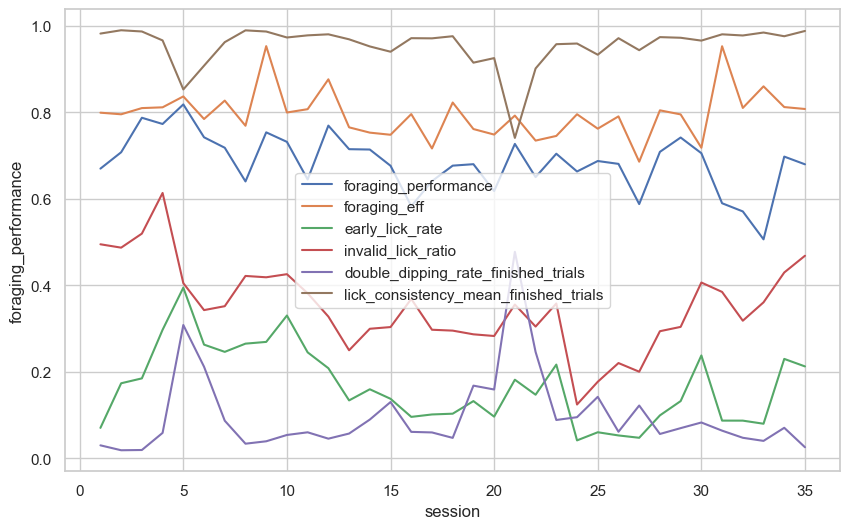

In [71]:
sns.set_theme(style="whitegrid")

testing_df = session_df_filt.loc[session_df_filt['subject_id'] == 741210]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=testing_df, x='session', y='foraging_performance', label='foraging_performance')
sns.lineplot(data=testing_df, x='session', y='foraging_eff', label='foraging_eff')
sns.lineplot(data=testing_df, x='session', y='early_lick_rate', label='early_lick_rate')
sns.lineplot(data=testing_df, x='session', y='invalid_lick_ratio', label='invalid_lick_ratio')
sns.lineplot(data=testing_df, x='session', y='double_dipping_rate_finished_trials', label='double_dipping_rate_finished_trials')
sns.lineplot(data=testing_df, x='session', y='lick_consistency_mean_finished_trials', label='lick_consistency_mean_finished_trials')

plt.show()



<Axes: xlabel='new_session', ylabel='new_column'>

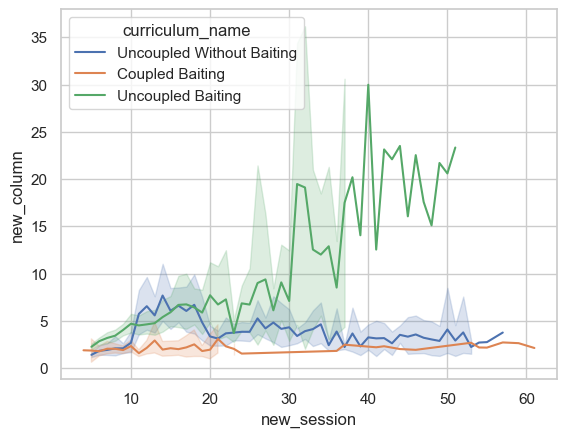

In [155]:
test_session_df = session_df.copy()

test_session_df['new_column'] = np.where(
    (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials']) != 0,
    1 / (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials']),
    np.inf
)

test_session_df = bu.add_session_column(test_session_df)

test_session_df.loc[:, ['subject_id', 'new_session', 'new_column']]

stage = 'STAGE_FINAL'

test_session_df = test_session_df.loc[test_session_df['current_stage_actual'] == stage]

sns.lineplot(data=test_session_df, x='new_session', y='new_column',  hue='curriculum_name')